# WORD SENTIMENT ANALYSIS - TESLA


*   This is to support part V.D in our paper.
*   The purpose of the code is to find the most common words / topics that can influence stock price. We tried with Wordcloud and TF-IDF method.
We conduct word sentiment for Tesla stock as a sample. We will use same method and coding for other stocks.

In [ ]:
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 6

In [ ]:
#Import company stock name, tweet_ID, company tweet, company stock value
company = pd.read_csv('Company.csv')
tweet_id = pd.read_csv('Company_Tweet.csv')
tweet = pd.read_csv('Tweet.csv')
company_value = pd.read_csv('CompanyValues.csv')

In [ ]:
#Add return per day to company_value table and filter Tesla value
company_value['returns'] = company_value.sort_values('day_date').groupby(['ticker_symbol']).close_value.pct_change()
Tesla_value = company_value[company_value['ticker_symbol']=='TSLA'].sort_values('day_date')
Tesla_value.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value,returns
16959,TSLA,2010-06-29,23.89,18751150,19.00,25.0000,17.54,NaN
16958,TSLA,2010-06-30,23.83,17165210,25.79,30.4192,23.30,-0.002512
16957,TSLA,2010-07-01,21.96,8216789,25.00,25.9200,20.27,-0.078473
16956,TSLA,2010-07-02,19.20,5135795,23.00,23.1000,18.71,-0.125683
16955,TSLA,2010-07-06,16.11,6858092,20.00,20.0000,15.83,-0.160937


In [ ]:
# Tesla sentiment_scores was calculated by using code in the file "Project Sentiment Analysis Setup" and exported to a csv file from previous step. 
# Since the time to run calculation is long (3-4 hours for Tesla), we import it from csv file.
Tesla = pd.read_csv('/Users/17142/Desktop/Tesla_engagement update.csv')
Tesla.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,total_engangement,sentiment_scores,score
0,550793298357391360,TSLA,ScoutingGW,2015-01-01,"#bluechips like $TSLA, $AAPL, $DIS, $TWTR & NV...",0,0,3,3,"{'neg': 0.0, 'neu': 0.752, 'pos': 0.248, 'comp...",Positive
1,550780769497808896,TSLA,SharePlanner,2015-01-01,2014 Was A Great Year of Trading In The Splash...,1,0,1,2,"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou...",Positive
2,550703624544718848,TSLA,laurenholmesNYC,2015-01-01,Best Trade: $AAPL; $GOOG $TSLA $YHOO $LNKD I r...,0,1,2,3,"{'neg': 0.0, 'neu': 0.724, 'pos': 0.276, 'comp...",Positive
3,550676585393569792,TSLA,laurenholmesNYC,2015-01-01,$AAPL $ARWR $TSLA $BABA Wish everyone happy ne...,0,1,1,2,"{'neg': 0.0, 'neu': 0.729, 'pos': 0.271, 'comp...",Positive
4,550673738161610752,TSLA,laurenholmesNYC,2015-01-01,$AAPL $TSLA $GILD $CELG $BABA $SCTY $RIG $WFM ...,0,1,1,2,"{'neg': 0.087, 'neu': 0.74, 'pos': 0.173, 'com...",Positive


In [ ]:
# Replace score by numeric score
def parse_label(label):
    options = {'Positive': 1, 'Neutral': 0.5, 'Negative': -1}
    return options[label]

Tesla['score_label'] = Tesla['score'].map(parse_label)
Tesla.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,total_engangement,sentiment_scores,score,score_label
0,550793298357391360,TSLA,ScoutingGW,2015-01-01,"#bluechips like $TSLA, $AAPL, $DIS, $TWTR & NV...",0,0,3,3,"{'neg': 0.0, 'neu': 0.752, 'pos': 0.248, 'comp...",Positive,1.0
1,550780769497808896,TSLA,SharePlanner,2015-01-01,2014 Was A Great Year of Trading In The Splash...,1,0,1,2,"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou...",Positive,1.0
2,550703624544718848,TSLA,laurenholmesNYC,2015-01-01,Best Trade: $AAPL; $GOOG $TSLA $YHOO $LNKD I r...,0,1,2,3,"{'neg': 0.0, 'neu': 0.724, 'pos': 0.276, 'comp...",Positive,1.0
3,550676585393569792,TSLA,laurenholmesNYC,2015-01-01,$AAPL $ARWR $TSLA $BABA Wish everyone happy ne...,0,1,1,2,"{'neg': 0.0, 'neu': 0.729, 'pos': 0.271, 'comp...",Positive,1.0
4,550673738161610752,TSLA,laurenholmesNYC,2015-01-01,$AAPL $TSLA $GILD $CELG $BABA $SCTY $RIG $WFM ...,0,1,1,2,"{'neg': 0.087, 'neu': 0.74, 'pos': 0.173, 'com...",Positive,1.0


In [ ]:
# Calculate the total_score = total_engagement * score_label
total_score = []
for i in range(len(Tesla['total_engangement'])):
    total_score.append(Tesla['total_engangement'][i]*Tesla['score_label'][i])
len(total_score)

1096868

In [ ]:
# Filter Tesla positive review with total score > 100.
Tesla['total_score'] = total_score
Tesla_pos = Tesla[(Tesla['total_score']>100) & (Tesla['score']=='Positive')].sort_values('total_score',ascending = False).reset_index()
Tesla_pos.head()

,index,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,total_engangement,sentiment_scores,score,score_label,total_score
0,1066959,1199424478536753155,TSLA,AlexSibila,2019-11-26,~Tesla feature request thread~Feel free to rep...,563,48,662,1273,"{'neg': 0.0, 'neu': 0.875, 'pos': 0.125, 'comp...",Positive,1.0,1273.0
1,1090143,1209424426904801280,TSLA,YCalenge,2019-12-24,"Last night, $TSLA was worth $76 B. Daimler was...",234,172,835,1241,"{'neg': 0.0, 'neu': 0.813, 'pos': 0.187, 'comp...",Positive,1.0,1241.0
2,200015,632188388091662336,TSLA,philstockworld,2015-08-14,"Honesty = ""@elonmusk, who already has $10,000M...",0,931,252,1183,"{'neg': 0.117, 'neu': 0.697, 'pos': 0.187, 'co...",Positive,1.0,1183.0
3,580693,1025852237053091840,TSLA,auto_cynical,2018-08-04,Candidate for best Twitter exchange with a $TS...,19,203,954,1176,"{'neg': 0.0, 'neu': 0.656, 'pos': 0.344, 'comp...",Positive,1.0,1176.0
4,381060,882955763618123776,TSLA,philstockworld,2017-07-06,"Yesterday's Nasdaq (QQQ) short made $1,500 per...",0,984,166,1150,"{'neg': 0.0, 'neu': 0.878, 'pos': 0.122, 'comp...",Positive,1.0,1150.0


In [ ]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\17142\anaconda3\python.exe -m pip install --upgrade pip' command.


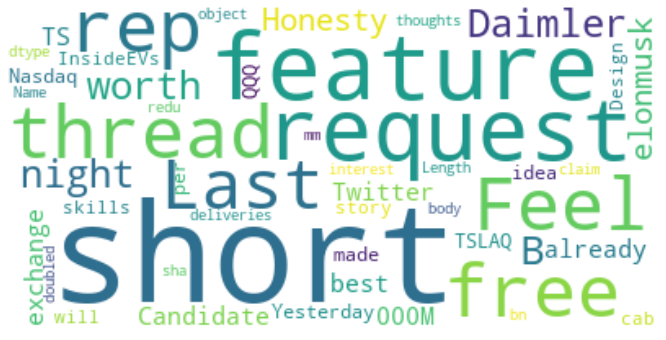

In [ ]:
# Generate WordCloud for Tesla_pos dataframe
from wordcloud import WordCloud, STOPWORDS
my_stop_words = STOPWORDS
my_stop_words.update(['Tesla','TSLA'])
Tesla_pos_cloud = WordCloud(background_color='white',stopwords = my_stop_words).generate(str(Tesla_pos.body))
plt.imshow(Tesla_pos_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

In [ ]:
# Use TFIDF score to analyze Tesla_pos
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
my_pattern = r'\b[^\d\W][^\d\W]+\b'
vect = TfidfVectorizer(ngram_range=(2, 4), max_features = 50, max_df = 5, token_pattern = my_pattern, stop_words=ENGLISH_STOP_WORDS).fit(Tesla_pos.body)
X_Tesla_pos = vect.transform(Tesla_pos.body)
X_Tesla_pos = pd.DataFrame(X_Tesla_pos.toarray(),columns = vect.get_feature_names())
X_Tesla_pos

,baba amzn,battery tech,billion cash,cash burn,china huge,china just,china modelx,china sales,china teslachina gigafactory,chinese model owners,...,tesla registered,tesla tslaq,times tsla,trade carefully tsla,um ah,value tesla,world better,worth bil,year award,youtube com powertargettrades
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print('The most popular words among positve Tesla tweets: \n' + str(X_Tesla_pos.max().keys()))

The most popular words among positve Tesla tweets: 
Index(['baba amzn', 'battery tech', 'billion cash', 'cash burn', 'china huge',
       'china just', 'china modelx', 'china sales',
       'china teslachina gigafactory', 'chinese model owners',
       'delete account', 'dream car', 'ev tax', 'federal tax', 'fsd tsla',
       'fud tesla', 'gaap net income', 'gene munster', 'general public',
       'huge gains', 'landing rockets', 'looks like tesla', 'lot tsla',
       'love tesla tsla', 'mil shares', 'model arrived', 'model miles',
       'model taking', 'mr musk', 'north america', 'old world',
       'picture thinking', 'pre order', 'resale value', 'reservation holders',
       'right tslaq', 'robot drone', 'securities laws', 'short burn',
       'tesla elonmusk tesla', 'tesla registered', 'tesla tslaq', 'times tsla',
       'trade carefully tsla', 'um ah', 'value tesla', 'world better',
       'worth bil', 'year award', 'youtube com powertargettrades'],
      dtype='object')


NEGATIVE TWEETS ANALYSIS

In [ ]:
# Filter Tesla negative review.
Tesla_neg = Tesla[(Tesla['total_score']<-100) & (Tesla['score']=='Negative')].sort_values('total_score',ascending = True).reset_index()
Tesla_neg

,index,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,total_engangement,sentiment_scores,score,score_label,total_score
0,563966,1021481848403382272,TSLA,QTRResearch,2018-07-23,"Guys - I'm beside myself & before you ask, thi...",207,317,899,1423,"{'neg': 0.114, 'neu': 0.886, 'pos': 0.0, 'comp...",Negative,-1.0,-1423.0
1,702157,1054728662786826240,TSLA,CitronResearch,2018-10-23,$TSLA dropping earnings on top of $F tomorrow ...,148,308,861,1317,"{'neg': 0.148, 'neu': 0.805, 'pos': 0.047, 'co...",Negative,-1.0,-1317.0
2,559956,1020077355346169857,TSLA,vincent13031925,2018-07-19,"Tesla Spokesperson, Regarding The Earlier Need...",38,256,986,1280,"{'neg': 0.237, 'neu': 0.669, 'pos': 0.094, 'co...",Negative,-1.0,-1280.0
3,663533,1045404879341137921,TSLA,Reuters,2018-09-27,SEC files lawsuit against Tesla CEO Elon Musk ...,56,630,585,1271,"{'neg': 0.26, 'neu': 0.639, 'pos': 0.1, 'compo...",Negative,-1.0,-1271.0
4,1092523,1210396465249558530,TSLA,BomsteinRick,2019-12-27,"My wife, who knows zero about finance, told me...",149,94,972,1215,"{'neg': 0.073, 'neu': 0.927, 'pos': 0.0, 'comp...",Negative,-1.0,-1215.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3455,807557,1100360482609868800,TSLA,evannex_com,2019-02-26,"Sure, #ElonMusk needs to show some Twitter res...",2,22,77,101,"{'neg': 0.084, 'neu': 0.867, 'pos': 0.049, 'co...",Negative,-1.0,-101.0
3456,810790,1101108753091514369,TSLA,PnNovy,2019-02-28,Tesla alleged $2B loan in China will required ...,7,14,80,101,"{'neg': 0.124, 'neu': 0.822, 'pos': 0.054, 'co...",Negative,-1.0,-101.0
3457,812861,1101256517158948864,TSLA,orthereaboot,2019-02-28,Holy hell are things deteriorating exponential...,4,11,86,101,"{'neg': 0.139, 'neu': 0.861, 'pos': 0.0, 'comp...",Negative,-1.0,-101.0
3458,793815,1094097306947911681,TSLA,CathieDWood,2019-02-09,"Thank you, Matt. We disclose our holdings and...",12,9,80,101,"{'neg': 0.106, 'neu': 0.837, 'pos': 0.057, 'co...",Negative,-1.0,-101.0


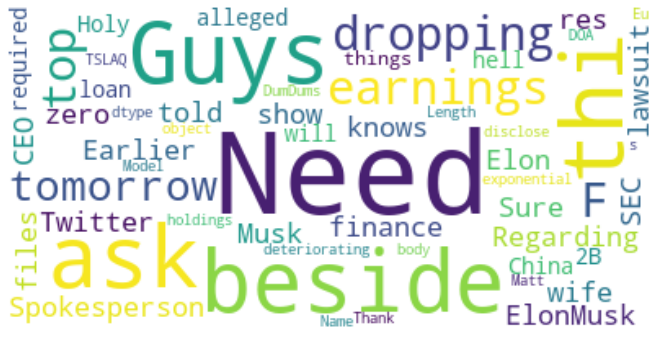

In [ ]:
# Generate WordCloud for Tesla_neg dataframe
Tesla_neg_cloud = WordCloud(background_color='white',stopwords = my_stop_words).generate(str(Tesla_neg.body))
plt.imshow(Tesla_neg_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

In [ ]:
# Use TFIDF score to analyze Tesla_neg
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
my_pattern = r'\b[^\d\W][^\d\W]+\b'
vect = TfidfVectorizer(ngram_range=(2, 4), max_features = 50, max_df = 5, token_pattern = my_pattern, stop_words=ENGLISH_STOP_WORDS).fit(Tesla_neg.body)
X_Tesla_neg = vect.transform(Tesla_neg.body)
X_Tesla_neg = pd.DataFrame(X_Tesla_neg.toarray(),columns = vect.get_feature_names())
X_Tesla_neg

,automotive gross,bullshit bullshit,bullshit bullshit bullshit,bullshit bullshit bullshit bullshit,buying stock,ceo musk,china model,consumer reports,cut prices,demand problems,...,tesla today,teslarati tsla,teslarati tsla tesla,traditional automakers,tsla baba,tsla fsd,tsla tweet,tsla using,tsla years,vs est
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print('The most popular words among negative Tesla tweets: \n' + str(X_Tesla_neg.max().keys()))

The most popular words among negative Tesla tweets: 
Index(['automotive gross', 'bullshit bullshit', 'bullshit bullshit bullshit',
       'bullshit bullshit bullshit bullshit', 'buying stock', 'ceo musk',
       'china model', 'consumer reports', 'cut prices', 'demand problems',
       'elon musk tesla', 'elonmusk tsla tslaq', 'feel like', 'fud fud',
       'gas car', 'https plainsite org dockets', 'industry tesla',
       'lawsuit tesla', 'lie tsla', 'live stream', 'making cars',
       'martin tripp', 'mile range', 'money printer', 'org dockets',
       'passenger cars', 'plainsite org dockets', 'revs vs', 'revs vs est',
       'robotaxis road', 'scoop tesla', 'selling tsla', 'start car',
       'story elon', 'story elon musk', 'takes start', 'takes start car',
       'tesla bears', 'tesla cybertruck', 'tesla solar roof', 'tesla today',
       'teslarati tsla', 'teslarati tsla tesla', 'traditional automakers',
       'tsla baba', 'tsla fsd', 'tsla tweet', 'tsla using', 'tsla years',


# CONCLUSION:

A. POSITIVE TWEETS:
- Wordcloud shows the most frequent words appeared in Tweets. Majority of repeated words do not add value to stock movement. They basically common stock tweeting words; therefore, WordCloud method is not suitable to find important words.
- Tfidf considers the frequents words that do not repeat too much, so they are more accurate to reflect the sentiment of tweets. Some highlight keywords related to Tesla business are battery, china sales, dream car, robot drone, elonmusk, tesla value, landing rockets. Other important words related to trading tweet are huge gains, short burn, trade carefully tesla... So Tfidf is a more appropriate method to find common and important Tweet words.

B. NEGATIVE TWEETS:
- Same conclusion for Wordcloud and Tfidf when applying for negative tweets
- Some highlight negative keywords: cut prices, CEO Musk, Elon Musk Tesla, lawsuite tesla, lie tsla, selling tsla, tesla bears, tesla cybertruck, demand problem.